In [ ]:
!pip install transformers[torch] accelerate -U
!pip install torch datasets scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
import glob
import os
import torch
import numpy as np

from tqdm import tqdm
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 쿠팡 상품평 concat

In [ ]:
# 현재 디렉토리의 "product_kurly_review"로 시작하는 모든 CSV 파일 경로 가져오기
csv_files = glob.glob(os.path.join(os.getcwd(), "product_coupang*.csv"))

# 각 CSV 파일을 읽어서 리스트에 추가
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# 모든 데이터프레임을 하나로 연결
combined_df = pd.concat(dataframes, ignore_index=True)

# 결과 출력 또는 저장
print(combined_df.head())
combined_df.to_csv('combined_coupang_reviews.csv', index=False)

                                                 url  \
0  https://www.coupang.com/vp/products/6586372374...   
1  https://www.coupang.com/vp/products/6586372374...   
2  https://www.coupang.com/vp/products/6586372374...   
3  https://www.coupang.com/vp/products/6586372374...   
4  https://www.coupang.com/vp/products/6586372374...   

                                              review review_date  rate  \
0  종근당건강 프로메가 오메가3 트리플 장용성, 60정, 1개 후기.\n\n요새 눈이 ...  2024.06.17     5   
1  <내돈내산 솔직후기>\n저의 솔직한 리뷰가 구매하시는 분들께 도움이 되길 바랍니다❤...  2024.06.16     5   
2  저희집 오메가입니다.\n가족들 모두 오메가를 먹는데 어취향 장난아녔거든요.\n일부러...  2024.06.14     5   
3  안녕하세요.\n최대한 솔직한 후기를 쓰기 위해 노력하고 있습니다.\n많은 참고가 되...  2024.06.14     5   
4  안녕하세요 :) 종근당건강 프로메가 오메가3 트리플 장용성 제품에 대한 내돈내산리뷰...  2024.06.10     5   

       date      time  
0  20240620  19:07:12  
1  20240620  19:07:12  
2  20240620  19:07:12  
3  20240620  19:07:12  
4  20240620  19:07:12  


In [ ]:
# 쿠팡 데이터 로드
coupang_df = pd.read_csv('combined_coupang_reviews.csv')

# 레이블 확인
print(coupang_df['rate'].value_counts())

# 다수 클래스와 소수 클래스 구분
df_majority = coupang_df[coupang_df['rate'] == 5]
df_minority_4 = coupang_df[coupang_df['rate'] == 4]
df_minority_3 = coupang_df[coupang_df['rate'] == 3]
df_minority_2 = coupang_df[coupang_df['rate'] == 2]
df_minority_1 = coupang_df[coupang_df['rate'] == 1]

# 다수 클래스 크기에 맞추어 소수 클래스 오버샘플링
df_minority_4_upsampled = resample(df_minority_4,
                                   replace=True,     # 샘플을 복제하여 오버샘플링
                                   n_samples=len(df_majority),  # 다수 클래스 샘플 수에 맞추어 변경
                                   random_state=42)  # 재현성을 위한 랜덤 시드 설정
df_minority_3_upsampled = resample(df_minority_3,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)
df_minority_2_upsampled = resample(df_minority_2,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)
df_minority_1_upsampled = resample(df_minority_1,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)

# 오버샘플링된 데이터프레임 결합
df_upsampled = pd.concat([df_majority, df_minority_4_upsampled, df_minority_3_upsampled, df_minority_2_upsampled, df_minority_1_upsampled])

# 데이터 확인
print(df_upsampled['rate'].value_counts())
df_upsampled.to_csv('coupang_reviews_oversampled.csv', index=False)

rate
5    11273
4      827
3       94
1       56
2       31
Name: count, dtype: int64
rate
5    11273
4    11273
3    11273
2    11273
1    11273
Name: count, dtype: int64


In [ ]:
!nvidia-smi

Mon Jun 24 08:03:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 데이터 불러오기
data = pd.read_csv('coupang_reviews_oversampled.csv')

# 텍스트와 라벨 분리
texts = data['review'].tolist()
labels = data['rate'].tolist()

# 라벨 값 확인 및 변환 (1~5 -> 0~4)
labels = [label - 1 for label in labels]
print(f"Unique labels in dataset: {np.unique(labels)}")

# 학습/검증 데이터셋 분리
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")

# 토큰화 함수 정의
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, return_tensors='pt')

# 데이터 토큰화
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, train_labels)
val_dataset = ReviewsDataset(val_encodings, val_labels)

Unique labels in dataset: [0 1 2 3 4]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# 모델 로드 및 파인 튜닝
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base-v2022", num_labels=5)

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# 트레이너 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 모델 학습
trainer.train()

# 모델 저장
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')

# 모델 평가
trainer.evaluate()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-0d426bb4f98d>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.000300,0.003116
2,0.000100,0.002620
3,0.000000,0.003195


<ipython-input-8-0d426bb4f98d>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-0d426bb4f98d>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-0d426bb4f98d>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-8-0d426bb4f98d>:34: UserWarning: To copy construct from a 

{'eval_loss': 0.003195264609530568,
 'eval_runtime': 391.1555,
 'eval_samples_per_second': 28.82,
 'eval_steps_per_second': 1.802,
 'epoch': 3.0}

In [ ]:
from google.colab import files

# 로컬 사용 또는 런타임 에러 대비용 파일 압축
!zip -r fine_tuned_model.zip ./fine_tuned_model

# 모델 파일 다운로드
files.download('fine_tuned_model.zip')

  adding: fine_tuned_model/ (stored 0%)
  adding: fine_tuned_model/tokenizer.json (deflated 70%)
  adding: fine_tuned_model/model.safetensors (deflated 7%)
  adding: fine_tuned_model/config.json (deflated 55%)
  adding: fine_tuned_model/special_tokens_map.json (deflated 42%)
  adding: fine_tuned_model/tokenizer_config.json (deflated 75%)
  adding: fine_tuned_model/vocab.txt (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 기존 분석모델과의 비교 진행

In [ ]:
# 현재 디렉토리의 모든 CSV 파일 경로 가져오기
csv_files = glob.glob(os.path.join(os.getcwd(), "*.csv"))

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')
model.eval()

# 배치 크기를 256로 설정 => 첫트라이 32의 2^3 => 시스템RAM 사용량 피크 11.1gb
batch_size = 256

# 모든 CSV 파일에 대해 예측 수행 및 저장
for file in csv_files:
    # 데이터 로드
    data = pd.read_csv(file)

    # 결과 저장을 위한 리스트
    predicted_labels = []

    # 배치 처리
    for i in tqdm(range(0, len(data), batch_size)):
        # 배치 추출
        batch_texts = data['review_text'][i:i+batch_size].tolist()

        # 텍스트 토큰화
        new_encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

        # 예측 수행
        with torch.no_grad():
            outputs = model(**new_encodings)

        # 로짓(logits) 추출
        logits = outputs.logits

        # 예측된 레이블
        batch_predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
        # 예측된 레이블을 원래의 레이블 값으로 변환 (0~4 -> 1~5)
        batch_predicted_labels = batch_predicted_labels + 1

        # 예측된 레이블을 결과 리스트에 추가
        predicted_labels.extend(batch_predicted_labels)

    # 데이터에 예측된 레이블 추가
    data['predicted_rate'] = predicted_labels

    # 결과 저장
    new_filename = os.path.splitext(file)[0] + '_finetunning_sentiment.csv'
    data.to_csv(new_filename, index=False)

100%|██████████| 8/8 [43:20<00:00, 325.00s/it]


In [ ]:
# 새로운 데이터셋 로드
new_data = pd.read_csv('product_coupang_review_2024H1.csv')

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')
model.eval()

# 배치 크기 설정 - 첫트라이 - 38분
batch_size = 32

# 결과 저장을 위한 리스트
predicted_labels = []

# 배치 처리
for i in tqdm(range(0, len(new_data), batch_size)):
    # 배치 추출
    batch_texts = new_data['review'][i:i+batch_size].tolist()

    # 텍스트 토큰화
    new_encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

    # 예측 수행
    with torch.no_grad():
        outputs = model(**new_encodings)

    # 로짓(logits) 추출
    logits = outputs.logits

    # 예측된 레이블
    batch_predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    # 예측된 레이블을 원래의 레이블 값으로 변환 (0~4 -> 1~5)
    batch_predicted_labels = batch_predicted_labels + 1

    # 예측된 레이블을 결과 리스트에 추가
    predicted_labels.extend(batch_predicted_labels)

# 새로운 데이터셋에 예측된 레이블 추가
new_data['predicted_rate'] = predicted_labels

# 결과 저장
new_data.to_csv('product_coupang_review_2024H1_finetunning_sentiment.csv', index=False)

100%|██████████| 35/35 [38:56<00:00, 66.76s/it]


In [ ]:
# 새로운 데이터셋 로드
new_data = pd.read_csv('product_coupang_review_2024H1.csv')

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')
model.eval()

# 배치 크기 설정 - 첫트라이 - 38분
batch_size = 32

# 결과 저장을 위한 리스트
predicted_labels = []

# 배치 처리
for i in tqdm(range(0, len(new_data), batch_size)):
    # 배치 추출
    batch_texts = new_data['review'][i:i+batch_size].tolist()

    # 텍스트 토큰화
    new_encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

    # 예측 수행
    with torch.no_grad():
        outputs = model(**new_encodings)

    # 로짓(logits) 추출
    logits = outputs.logits

    # 예측된 레이블
    batch_predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    # 예측된 레이블을 원래의 레이블 값으로 변환 (0~4 -> 1~5)
    batch_predicted_labels = batch_predicted_labels + 1

    # 예측된 레이블을 결과 리스트에 추가
    predicted_labels.extend(batch_predicted_labels)

# 새로운 데이터셋에 예측된 레이블 추가
new_data['predicted_rate'] = predicted_labels

# 결과 저장
new_data.to_csv('product_coupang_review_2024H1_finetunning_sentiment.csv', index=False)

 86%|████████▌ | 30/35 [39:08<06:31, 78.28s/it]


KeyboardInterrupt: 

In [ ]:
data = {
    'review_text': [
        '완전 별로 이상해 반품'
    ]
}

# 데이터 프레임 생성
df = pd.DataFrame(data)
df.to_csv('test.csv', index=False)

In [ ]:
# 현재 디렉토리의 모든 CSV 파일 경로 가져오기
csv_files = glob.glob(os.path.join(os.getcwd(), "*.csv"))

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')
model.eval()

# 배치 크기를 256로 설정 => 첫트라이 32의 2^3 => 시스템RAM 사용량 피크 11.1gb
batch_size = 256

# 모든 CSV 파일에 대해 예측 수행 및 저장
for file in csv_files:
    # 데이터 로드
    data = pd.read_csv(file)

    # 결과 저장을 위한 리스트
    predicted_labels = []

    # 배치 처리
    for i in tqdm(range(0, len(data), batch_size)):
        # 배치 추출
        batch_texts = data['review_text'][i:i+batch_size].tolist()

        # 텍스트 토큰화
        new_encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

        # 예측 수행
        with torch.no_grad():
            outputs = model(**new_encodings)

        # 로짓(logits) 추출
        logits = outputs.logits

        # 예측된 레이블
        batch_predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
        # 예측된 레이블을 원래의 레이블 값으로 변환 (0~4 -> 1~5)
        batch_predicted_labels = batch_predicted_labels + 1

        # 예측된 레이블을 결과 리스트에 추가
        predicted_labels.extend(batch_predicted_labels)

    # 데이터에 예측된 레이블 추가
    data['predicted_rate'] = predicted_labels

    # 결과 저장
    new_filename = os.path.splitext(file)[0] + '_finetunning_sentiment.csv'
    data.to_csv(new_filename, index=False)

100%|██████████| 8/8 [1:09:08<00:00, 518.62s/it]


In [ ]:
# 현재 디렉토리의 모든 CSV 파일 경로 가져오기
csv_files = glob.glob(os.path.join(os.getcwd(), "*.csv"))

# 모든 CSV 파일을 읽어서 데이터 프레임으로 병합
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# 데이터 프레임 병합
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv('product_kurly_review_2024_sa.csv', index=False)

In [ ]:
combined_df.predicted_rate.value_counts()

predicted_rate
5    13557
4     1344
1      142
2       45
3       22
Name: count, dtype: int64

## 쿠팡 새로운 리뷰 적용

In [ ]:
csv_files = glob.glob(os.path.join(os.getcwd(), "product_coupang_review_20240615.csv"))
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')
model.eval()

# 배치 크기를 256로 설정 => 첫트라이 32의 2^3 => 시스템RAM 사용량 피크 11.1gb
batch_size = 256

for file in csv_files:
    data = pd.read_csv(file)
    # 결과 저장을 위한 리스트
    predicted_labels = []

    # 배치 처리
    for i in tqdm(range(0, len(data), batch_size)):
        batch_texts = data['review'][i:i+batch_size].tolist()
        new_encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**new_encodings)
        logits = outputs.logits
        batch_predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
        # 예측된 레이블을 원래의 레이블 값으로 변환 (0~4 -> 1~5)
        batch_predicted_labels = batch_predicted_labels + 1
        predicted_labels.extend(batch_predicted_labels)

    # 데이터에 예측된 레이블 추가
    data['predicted_rate'] = predicted_labels

    # 결과 저장
    new_filename = os.path.splitext(file)[0] + '_finetunning_sentiment.csv'
    data.to_csv(new_filename, index=False)

100%|██████████| 11/11 [1:52:12<00:00, 612.06s/it]


In [ ]:
df = pd.read_csv('product_coupang_review_20240616_finetunning_sentiment.csv')

In [ ]:
# 두 칼럼의 값이 다른 행을 필터링
different_rows = df[df['rate'] != df['predicted_rate']]

# 해당 행들의 review 칼럼을 추출
review_data = different_rows['review']


In [ ]:
different_rows['predicted_rate'].value_counts()

predicted_rate
5    104
4     41
1      5
Name: count, dtype: int64

In [ ]:
different_rows['rate'].value_counts()

rate
4    89
5    24
3    24
1     9
2     4
Name: count, dtype: int64

In [ ]:
print(different_rows[different_rows['predicted_rate'] == 4].review)

141     주로 코스트고에서 구매 했었는데\n이번에는 쿠팡에서 구매 해 봤습니다.\n또 쿠팡에...
145     믿고먹는거임. 다만...기억력 좋아지게하려고 먹는건데.....먹는걸 잊어버림...혹...
309     모 브랜드시켜먹다 맛좋은데 비싸서 구경하다\n싸고 평이 좋길래 남편 먹이려고 샀어요...
314     새벽에 도착하자마자 공복에 뮬에타서 먹었는데요 다행히 설사는 없네요. 몸에 맞나봐요...
324     모 브랜드시켜먹다 맛좋은데 비싸서 구경하다\n싸고 평이 좋길래 남편 먹이려고 샀어요...
329     새벽에 도착하자마자 공복에 뮬에타서 먹었는데요 다행히 설사는 없네요. 몸에 맞나봐요...
380     모 브랜드시켜먹다 맛좋은데 비싸서 구경하다\n싸고 평이 좋길래 남편 먹이려고 샀어요...
385     새벽에 도착하자마자 공복에 뮬에타서 먹었는데요 다행히 설사는 없네요. 몸에 맞나봐요...
403     모 브랜드시켜먹다 맛좋은데 비싸서 구경하다\n싸고 평이 좋길래 남편 먹이려고 샀어요...
408     새벽에 도착하자마자 공복에 뮬에타서 먹었는데요 다행히 설사는 없네요. 몸에 맞나봐요...
525     운동 후에나 간식으로 먹으려고 샀어요\n먹어보니 확실히 초콜릿바랑은 다르네요\n훨씬...
570                     효과는 잘 모르겠....\n\n먹기 편한 제품인건 확실해요~
907     알갱이가 너무 크고 일단 캡슐을 까면 비린내가 확 나요.\n기존에 먹던제품은 이거 ...
1077                             좋은데, 가격이자꾸 슬금슬금 오르는듯요...
1078                             지인추천으로 읽어봤는데 생각보다..재미없네요
1132    피부는 콜라겐 입니다. 바르는 것도 중요하지만 먹는게 더 중요한거 같아요. 피부 좋...
1136                              있는것보다 분말로 먹는것이 더 효과있는느낌
1338    약간 실리콘

## 모델평가

In [ ]:
# 데이터 불러오기
data = pd.read_csv('coupang_reviews_oversampled.csv')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_model')

# 텍스트와 라벨 분리
texts = data['review'].tolist()
labels = data['rate'].tolist()

# 라벨 값 확인 및 변환 (1~5 -> 0~4)
labels = [label - 1 for label in labels]
print(f"Unique labels in dataset: {np.unique(labels)}")

# 학습/검증 데이터셋 분리
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
# 토큰화 함수 정의
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, return_tensors='pt')
# 데이터 토큰화
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, train_labels)
val_dataset = ReviewsDataset(val_encodings, val_labels)

# 평가용 데이터셋 준비 (validation set을 evaluation set으로 사용)
eval_dataset = val_dataset

Unique labels in dataset: [0 1 2 3 4]


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 트레이너 설정 및 평가
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

# 모델 평가
eval_result = trainer.evaluate()

# 결과 출력
print(eval_result)

<ipython-input-6-3ee81c128853>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.003195264609530568, 'eval_accuracy': 0.9996451698749224, 'eval_precision': 0.9996458109410923, 'eval_recall': 0.9996451698749224, 'eval_f1': 0.999645174454081, 'eval_runtime': 375.3936, 'eval_samples_per_second': 30.03, 'eval_steps_per_second': 1.878}


<ipython-input-6-cd5efb9113dc>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metrics, y=values, palette=colors, ax=ax)


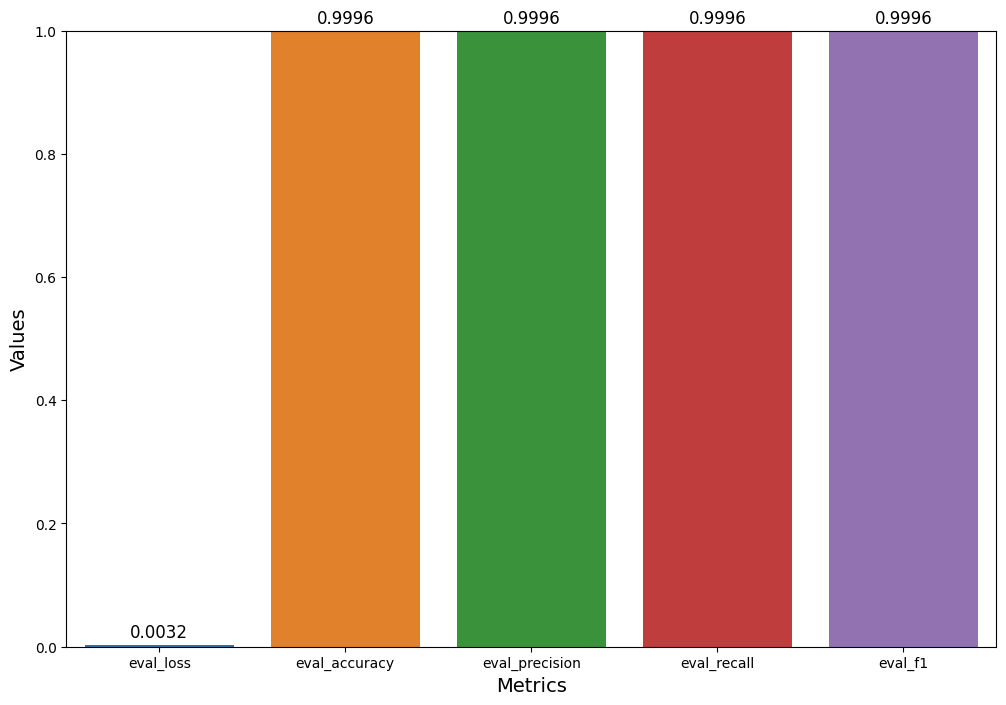

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 평가 결과
eval_result = {
    'eval_loss': 0.003195264609530568,
    'eval_accuracy': 0.9996451698749224,
    'eval_precision': 0.9996458109410923,
    'eval_recall': 0.9996451698749224,
    'eval_f1': 0.999645174454081,
    'eval_runtime': 375.3936,
    'eval_samples_per_second': 30.03,
    'eval_steps_per_second': 1.878
}

# 시각화할 지표 선택
metrics = ['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']
values = [eval_result[metric] for metric in metrics]

# 시각화할 지표 선택
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 각 지표에 대해 다른 색상

fig, ax = plt.subplots(figsize=(12, 8))

# 막대 그래프 그리기
bars = sns.barplot(x=metrics, y=values, palette=colors, ax=ax)

# 제목 및 축 레이블 설정
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Values', fontsize=14)
ax.set_ylim(0, 1)

# 값 레이블 추가
for bar in bars.patches:
    ax.annotate(format(bar.get_height(), '.4f'),
                (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=12)

plt.show()

In [ ]:
# 데이터 불러오기
file_1st_model = 'product_coupang_review_20240615_sentiment_analysis.csv'
file_3rd_model = 'product_coupang_review_20240615_finetunning_sentiment.csv'


data_1st = pd.read_csv(file_1st_model)
data_3rd = pd.read_csv(file_3rd_model)

print(data_1st.columns)
print(data_3rd.columns)

Index(['url', 'review', 'review_date', 'rate', 'date', 'time', 'clean_review',
       'sentiment'],
      dtype='object')
Index(['url', 'review', 'review_date', 'rate', 'date', 'time',
       'predicted_rate'],
      dtype='object')


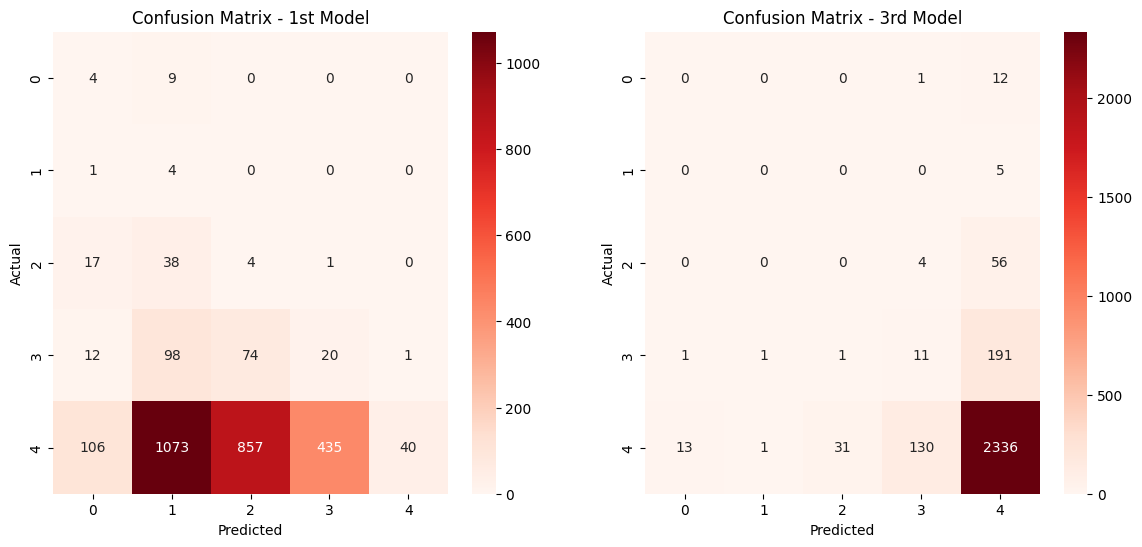

<ipython-input-26-6fe0fc8de8cd>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=mae_values, palette='viridis')


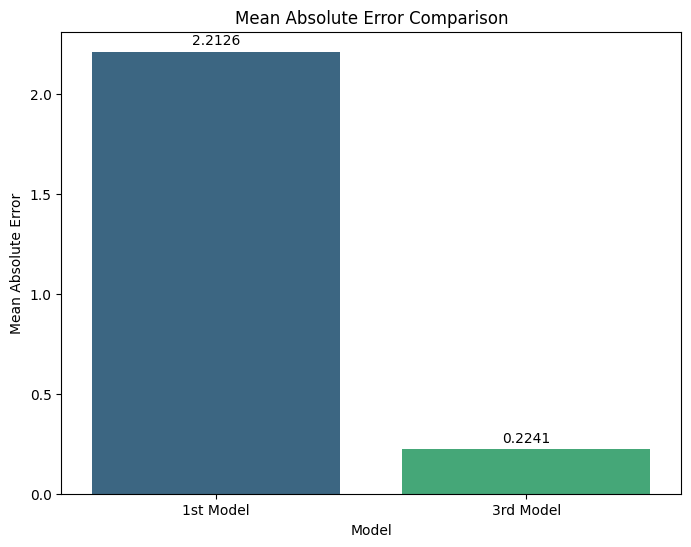

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_absolute_error, accuracy_score

# 예측값과 실제값
y_true = data_1st['rate'].astype(int)
y_pred_1st = data_1st['sentiment'].str.extract('(\d)').astype(int)
y_pred_3rd = data_3rd['predicted_rate'].astype(int)

# 혼동 행렬 계산
cm_1st = confusion_matrix(y_true, y_pred_1st)
cm_3rd = confusion_matrix(y_true, y_pred_3rd)

# 평균 절대 오차 계산
mae_1st = mean_absolute_error(y_true, y_pred_1st)
mae_3rd = mean_absolute_error(y_true, y_pred_3rd)

# 혼동 행렬 시각화
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_1st, annot=True, fmt='d', cmap='Reds', ax=ax[0])
ax[0].set_title('Confusion Matrix - 1st Model')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_3rd, annot=True, fmt='d', cmap='Reds', ax=ax[1])
ax[1].set_title('Confusion Matrix - 3rd Model')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

# 평균 절대 오차 시각화
mae_values = [mae_1st, mae_3rd]
model_names = ['1st Model', '3rd Model']

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=mae_values, palette='viridis')
plt.title('Mean Absolute Error Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.ylim(0, max(mae_values) + 0.1)
for i, v in enumerate(mae_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.show()

<ipython-input-25-078fb636a594>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mismatch_count_1st.index, y=mismatch_count_1st.values, palette='Blues', ax=ax[0])
<ipython-input-25-078fb636a594>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mismatch_count_3rd.index, y=mismatch_count_3rd.values, palette='Greens', ax=ax[1])


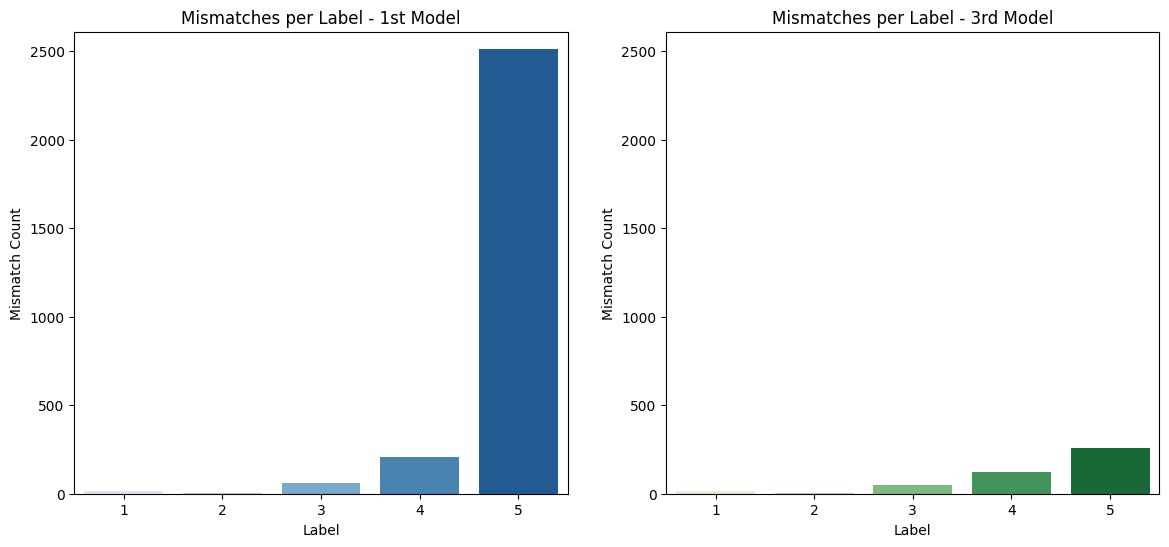

In [ ]:
# 틀린 예측 계산
data_1st['mismatch'] = (data_1st['rate'] != data_1st['sentiment'])
data_3rd['mismatch'] = (data_1st['rate'] != data_3rd['predicted_rate'])

# 레이블별 틀린 예측 개수 계산
mismatch_count_1st = data_1st.groupby('rate')['mismatch'].sum()
mismatch_count_3rd = data_3rd.groupby('rate')['mismatch'].sum()

# y축 범위 설정
y_max = max(mismatch_count_1st.max(), mismatch_count_3rd.max()) + 100  # 여유를 두어 설정

# 막대그래프로 시각화
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=mismatch_count_1st.index, y=mismatch_count_1st.values, palette='Blues', ax=ax[0])
ax[0].set_title('Mismatches per Label - 1st Model')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Mismatch Count')
ax[0].set_ylim(0, y_max)

sns.barplot(x=mismatch_count_3rd.index, y=mismatch_count_3rd.values, palette='Greens', ax=ax[1])
ax[1].set_title('Mismatches per Label - 3rd Model')
ax[1].set_xlabel('Label')
ax[1].set_ylabel('Mismatch Count')
ax[1].set_ylim(0, y_max)

plt.show()

<ipython-input-32-67b8cef8bf1f>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mismatch_count_1st.index, y=mismatch_count_1st.values, palette='Blues', ax=ax[1, 0])
<ipython-input-32-67b8cef8bf1f>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mismatch_count_3rd.index, y=mismatch_count_3rd.values, palette='Greens', ax=ax[1, 1])


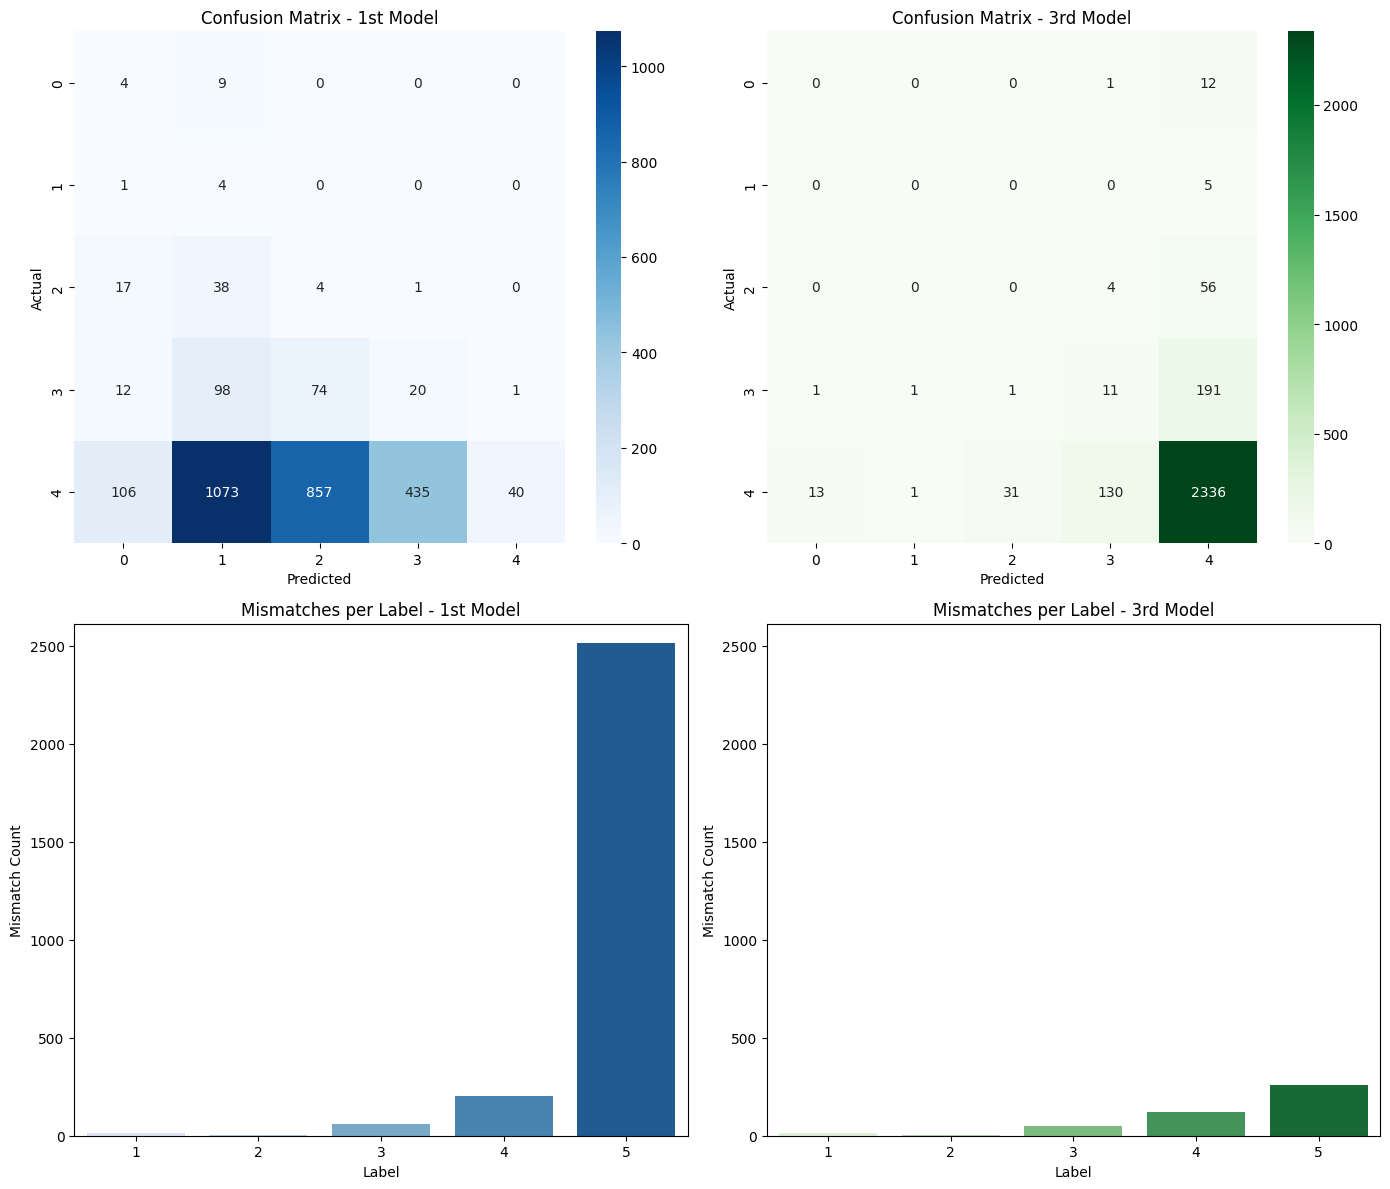

<ipython-input-32-67b8cef8bf1f>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values_1st, palette='Reds', ax=ax[0])
<ipython-input-32-67b8cef8bf1f>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values_3rd, palette='Blues', ax=ax[1])


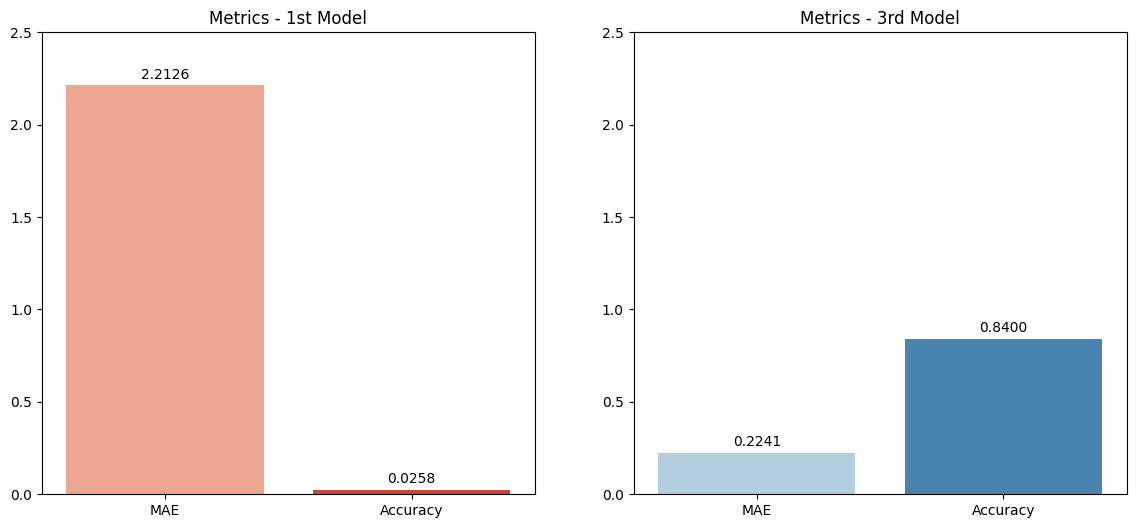

In [ ]:
from sklearn.metrics import confusion_matrix, mean_absolute_error, accuracy_score

# 예측값과 실제값
y_true = data_1st['rate'].astype(int)
y_pred_1st = data_1st['sentiment'].str.extract('(\d)').astype(int)
y_pred_3rd = data_3rd['predicted_rate'].astype(int)

# 틀린 예측 계산
data_1st['mismatch'] = (data_1st['rate'] != data_1st['sentiment'])
data_3rd['mismatch'] = (data_1st['rate'] != data_3rd['predicted_rate'])

# 레이블별 틀린 예측 개수 계산
mismatch_count_1st = data_1st.groupby('rate')['mismatch'].sum()
mismatch_count_3rd = data_3rd.groupby('rate')['mismatch'].sum()

# y축 범위 설정
y_max = max(mismatch_count_1st.max(), mismatch_count_3rd.max()) + 100  # 여유를 두어 설정

# 혼동 행렬 계산
cm_1st = confusion_matrix(y_true, y_pred_1st)
cm_3rd = confusion_matrix(y_true, y_pred_3rd)

# 평균 절대 오차 계산
mae_1st = mean_absolute_error(y_true, y_pred_1st)
mae_3rd = mean_absolute_error(y_true, y_pred_3rd)

# 정확도 계산
accuracy_1st = accuracy_score(y_true, y_pred_1st)
accuracy_3rd = accuracy_score(y_true, y_pred_3rd)

# 혼동 행렬 시각화
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

sns.heatmap(cm_1st, annot=True, fmt='d', cmap='Blues', ax=ax[0, 0])
ax[0, 0].set_title('Confusion Matrix - 1st Model')
ax[0, 0].set_xlabel('Predicted')
ax[0, 0].set_ylabel('Actual')

sns.heatmap(cm_3rd, annot=True, fmt='d', cmap='Greens', ax=ax[0, 1])
ax[0, 1].set_title('Confusion Matrix - 3rd Model')
ax[0, 1].set_xlabel('Predicted')
ax[0, 1].set_ylabel('Actual')

# 레이블별 틀린 예측 개수 시각화
sns.barplot(x=mismatch_count_1st.index, y=mismatch_count_1st.values, palette='Blues', ax=ax[1, 0])
ax[1, 0].set_title('Mismatches per Label - 1st Model')
ax[1, 0].set_xlabel('Label')
ax[1, 0].set_ylabel('Mismatch Count')
ax[1, 0].set_ylim(0, y_max)

sns.barplot(x=mismatch_count_3rd.index, y=mismatch_count_3rd.values, palette='Greens', ax=ax[1, 1])
ax[1, 1].set_title('Mismatches per Label - 3rd Model')
ax[1, 1].set_xlabel('Label')
ax[1, 1].set_ylabel('Mismatch Count')
ax[1, 1].set_ylim(0, y_max)

plt.tight_layout()
plt.show()

# y축 범위 설정
y_max = max(mismatch_count_1st.max(), mismatch_count_3rd.max()) + 100  # 여유를 두어 설정

# MAE와 정확도 시각화
metrics = ['MAE', 'Accuracy']
values_1st = [mae_1st, accuracy_1st]
values_3rd = [mae_3rd, accuracy_3rd]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=metrics, y=values_1st, palette='Reds', ax=ax[0])
ax[0].set_title('Metrics - 1st Model')
ax[0].set_ylim(0, 2.5)
for i, v in enumerate(values_1st):
    ax[0].text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')

sns.barplot(x=metrics, y=values_3rd, palette='Blues', ax=ax[1])
ax[1].set_title('Metrics - 3rd Model')
ax[1].set_ylim(0, 2.5)
for i, v in enumerate(values_3rd):
    ax[1].text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')

plt.show()